# Fundamental Programming Basics

In [1]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')


In [2]:
!pip install pyspark==2.3.0 

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [3]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [4]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

1. Parallel data processing in RDD

In [5]:
rdd = sc.parallelize(list(range(100)))
rdd.count()

100

2. Lambda function

In [6]:
rdd.take(20)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [7]:
#Incrementing value by 1 
rdd.map(lambda x: x+1).take(20)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [8]:
#Aggregating all elements from a list as Gaussian sum
sc.parallelize(list(range(1,101))).reduce(lambda a,b: a+b)

5050

3. EDA Voltage

In [9]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2021-10-18 06:59:19--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/claimed/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2021-10-18 06:59:19--  https://github.com/IBM/claimed/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/claimed/raw/master/coursera_ds/washing.parquet [following]
--2021-10-18 06:59:19--  https://github.com/IBM/claimed/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/claimed/master/coursera_ds/washing.parquet [following]
--2021-10-18 06:59:19

In [10]:
df = spark.read.parquet('washing.parquet')

In [11]:
df.createOrReplaceTempView("washing")
spark.sql("SELECT * FROM washing").show(10)

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [12]:
#create a voltage list, use the sample function in order to not blast spark driver or plotting library
result = spark.sql("SELECT voltage FROM washing WHERE voltage is NOT NULL")
result_array = result.rdd.map(lambda row : row.voltage).sample(False,0.1).collect()

#just print the 1st 15 elements
result_array[:15]

[234, 237, 228, 232, 226, 231, 229, 238, 222, 224, 222, 224, 244, 221, 232]

3.1 Visualizing voltage using a box plot to get the value distribution

In [13]:
#Activating the notebook to show the plots directly under the cell
%matplotlib inline

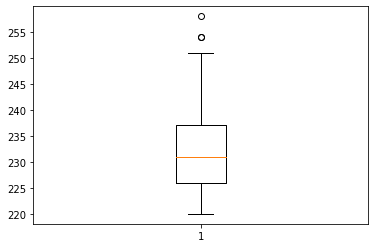

In [14]:
import matplotlib.pyplot as plt
plt.boxplot(result_array)
plt.show()

BOX PLOT: Mean (red line) around 230. 50% of all values are between 225 and 235 (blue box). Per default values up to 250 are not seen as outliers (little, black horizontal line). The "plus" symbols on top are definitely outliers.

3.2 TIME SERIES: time series of voltage

In [15]:
result = spark.sql("SELECT voltage,ts FROM washing WHERE voltage is NOT NULL ORDER BY ts ")
result_rdd = result.rdd.sample(False,0.1).map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
print(result_array_ts[:10])
print(result_array_voltage[:10])

[1547808725914, 1547808734922, 1547808740927, 1547808800960, 1547808836984, 1547808864037, 1547808876043, 1547808924097, 1547808981157, 1547808984163]
[223, 234, 235, 226, 224, 235, 221, 225, 228, 229]


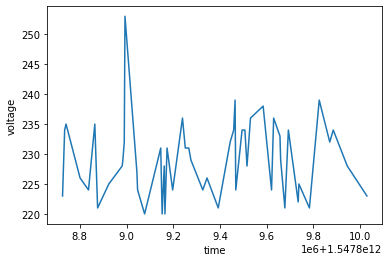

In [16]:
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

Finding date range of voltage

In [17]:
spark.sql("select min(ts),max(ts) from washing").show()

+-------------+-------------+
|      min(ts)|      max(ts)|
+-------------+-------------+
|1547808720911|1547810064867|
+-------------+-------------+



Plotting voltage for only 1 hour, from 1547808720911 as number of millisecond according to http://www.epochconverter.com/ 

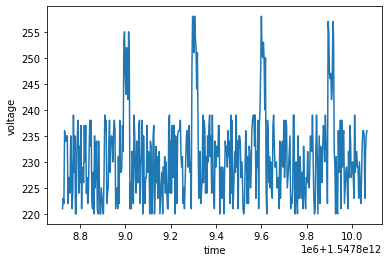

In [18]:
result = spark.sql(
"""
select voltage,ts from washing 
    where voltage is not null and 
    ts > 1547808720911 and
    ts <= 1547810064867+3600000
    order by ts asc
""")
result_rdd = result.rdd.map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

3.3 3D SCATTER PLOT

In [19]:
result_df = spark.sql("""
SELECT hardness,temperature,flowrate 
FROM washing
    WHERE hardness is NOT NULL and 
    temperature is NOT NULL and 
    flowrate is NOT NULL
""")
result_rdd = result_df.rdd.sample(False,0.1).map(lambda row : (row.hardness,row.temperature,row.flowrate))
result_array_hardness = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[0]).collect()
result_array_temperature = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[1]).collect()
result_array_flowrate = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[2]).collect()

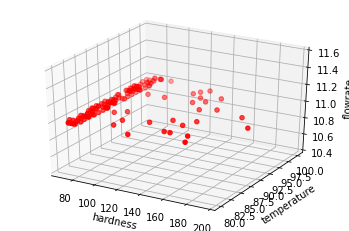

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_array_hardness,result_array_temperature,result_array_flowrate, c='r', marker='o')

ax.set_xlabel('hardness')
ax.set_ylabel('temperature')
ax.set_zlabel('flowrate')

plt.show()

The individual points resemble in some sort of plane. The following conclusions can be drawn from the plot:

- most of the data points are lying around hardness 60-80, temperature 80-100 and flowrate 80-100
- there are some outliers, especially when it comes to the range of hardness 100-200
- the data follows some narrow boundaries

3.4 HISTOGRAM: The frequency of occurences of values within this range

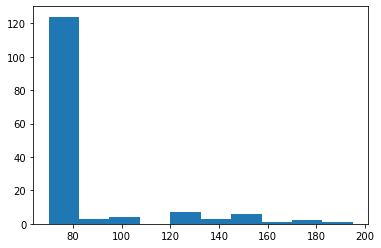

In [21]:
plt.hist(result_array_hardness)
plt.show()

The assumpion was correct, nearly all values are around 60-80 with very less values about that threshold.